In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import multiprocessing
from joblib import Parallel, delayed

# Uncertainty quantification script

Before looking at this script, please read the summer report and then the UQ instructions document. 

This cell defines all the necessary variables:

In [2]:
# both solutes we are plotting spectra for the specified solvent
all_solutes = {'methamino_dione': 'O=C(C=C1NC)N(C)C1=O', 'chloro_methamino_dione': 'O=C1N(C(C(NCC)=C1Cl)=O)C'}
solvent = "wtr"

# the states that the electronic transitions originate from 
targets = {0:'gs',1:'es1'}

# too convert the energy gap in eV to wavelengths
wavelength_eV_conv=1239.84193

# the range of wavelengths plotted in the spectra
wv = np.arange(300,700,1)

# defines the broadness the kde uses
broadness = 0.05

# to speed up generating the random sample data
num_cores = multiprocessing.cpu_count()

This cell contains the functions needed for this notebook:

In [3]:
# the below function is taken from ESTEEM, returns the sum of the gaussians 
# centred on the datapoints for the given wavelength
def spectral_value(wavelength,spectrum,broad):
    wav_in_eV=wavelength_eV_conv/wavelength
    p = 1/(broad*np.sqrt(2*np.pi))
    if len(spectrum)>0:
        abs_value=p*np.sum(spectrum[:,2]*np.exp(-0.5 * ((wav_in_eV-spectrum[:,1])/broad)**2))
    return abs_value

# given a stick spectrum, this function produces a broad spectrum by 
# summing the gaussians from spectral_value()
def broad_spec(idcs,n,full_stick_spectrum): 

    # generate n random indices, where n is the sample size
    rand_indx = np.random.choice(idcs,size=n, replace=True)
    
    # the random indices are used to take samples from the full stick spectrum
    random_samples = full_stick_spectrum[rand_indx]

    broad_spectrum = np.zeros((len(wv),3))

    # for each wavelength, the spectral_value() function is called
    for i,x in enumerate(wv):
      broad_spectrum[i,:] = np.array((x,spectral_value(x,random_samples,broadness),wavelength_eV_conv/x))

    # the maximum absorption/emission is normalised to 1
    broad_spectrum[:,1] = broad_spectrum[:,1] / np.max(broad_spectrum[:,1])

    return broad_spectrum

## Task a: Sampling error

In the below cell, you can choose two parameters to see how they affect the UQ estimations:

1) The number of data points to randomly sample
2) The number of times to randomly sample each sample size

In [4]:
# 1
n_samp = np.arange()
# to generate the plots shown in the instruction document:
# n_samp = np.arange(100,20000,100)

# 2
subsets = np.arange()
# to generate the plots shown in the instruction document:
# subsets = np.arange(1,31)

The below cell saves a nested dictionary called *all_samples*, which saves the broad spectrum for each sample, labelled with its solute, spectrum type (absorption and emission), sample size, and which subsample it is.

In [5]:
all_samples = {}

for solute in list(all_solutes):

  all_samples[f"{solute}"] = {}

  for targstr in targets.values():

    if targstr == "gs":
     spec_type = "abs"
    elif targstr == "es1":
      spec_type = "emis"

    all_samples[f"{solute}"][f"{spec_type}"] = {}

    # the below file holds the full stick spectrum which will be sampled from
    full_stick_spectrum = np.load(f'full_stick_spectrum_{solute}_{solvent}_{spec_type}.npy')

    # all the indices which can be used to randomly sample data points
    idcs = np.array(range(full_stick_spectrum.shape[0]))

    # how many times each sample is randomly selected
    for subset in subsets:

      all_samples[f"{solute}"][f"{spec_type}"][f"{subset}"] = {}

      # the results of each broad_spectrum for each value of n are stored in results
      results = Parallel(n_jobs=num_cores)(
                delayed(broad_spec)(idcs, n, full_stick_spectrum) for n in n_samp)

      # zip can be used to link the element in results with the corresponding n value
      for n, result in zip(n_samp, results):
          all_samples[f"{solute}"][f"{spec_type}"][f"{subset}"][f"{n}"] = result

A new dictionary can be produced which now stores the calculated $\lambda_{max}$ value for each sample's spectrum

In [6]:
lambdas = {"Solute":[], "Solvent":[], "Spec_Type":[],
              "Sample_Size":[], "N_Samples":[], "Lambda_Max":[]}

for solv in ["wtr"]:
  for solu in ["methamino_dione", "chloro_methamino_dione"]:
    for spec_type in ["emis", "abs"]:
      for n in n_samp:
        for subsampl in subsets:

          lambdas["Solute"].append(solu)
          lambdas["Solvent"].append(solv)
          lambdas["Spec_Type"].append(spec_type)
          lambdas["Sample_Size"].append(n)
          lambdas["N_Samples"].append(subsampl)

          broad_spectrum = all_samples[f"{solu}"][f"{spec_type}"][f"{subsampl}"][f"{n}"]

          # returns the index of the maximum intensity
          spec_peak_idx = np.argmax(broad_spectrum[:, 1])
          
          # the wavelength with the largest intensity
          lambda_max = broad_spectrum[spec_peak_idx,  0]

          lambdas["Lambda_Max"].append(lambda_max)


Now the sampling error graphs can be plotted. The line of best fit is used to calculate the slope, intercept and r-squared value. 

Do these match the values presented in the table? What is the smallest number of subsets required? For what sample size is the relationship no longer linear? 

('chloro_methamino_dione', 'wtr', 'abs')
R2 : 0.8885844214669867
Slope:  -0.4466146931267018
Intercept:  4.03466370017753

('chloro_methamino_dione', 'wtr', 'emis')
R2 : 0.9066391863060133
Slope:  -0.45924270425392477
Intercept:  5.548139465456842

('methamino_dione', 'wtr', 'abs')
R2 : 0.9050912391640619
Slope:  -0.46133608818047417
Intercept:  3.8796409546223964

('methamino_dione', 'wtr', 'emis')
R2 : 0.9202844864973178
Slope:  -0.46043270729071256
Intercept:  5.055405317570172



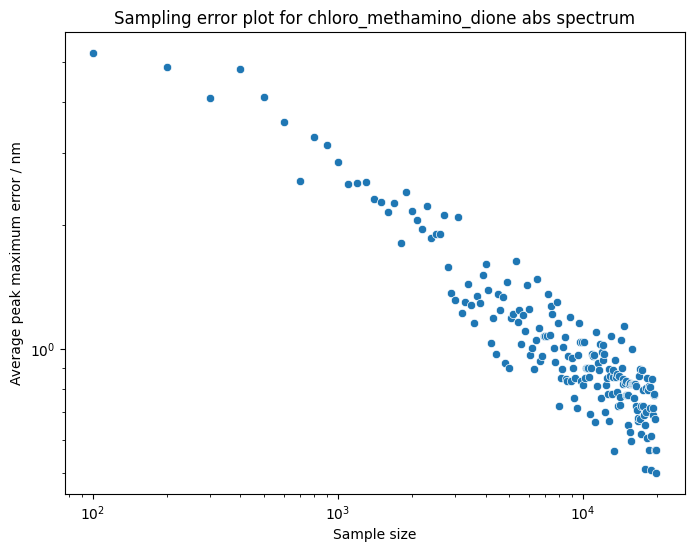

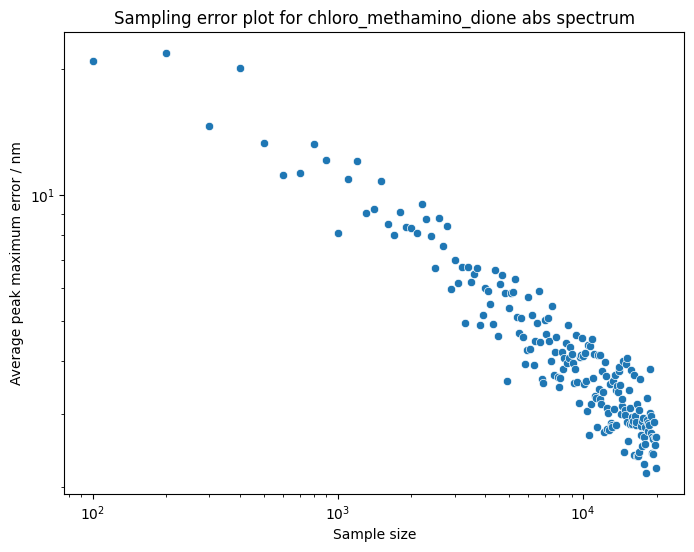

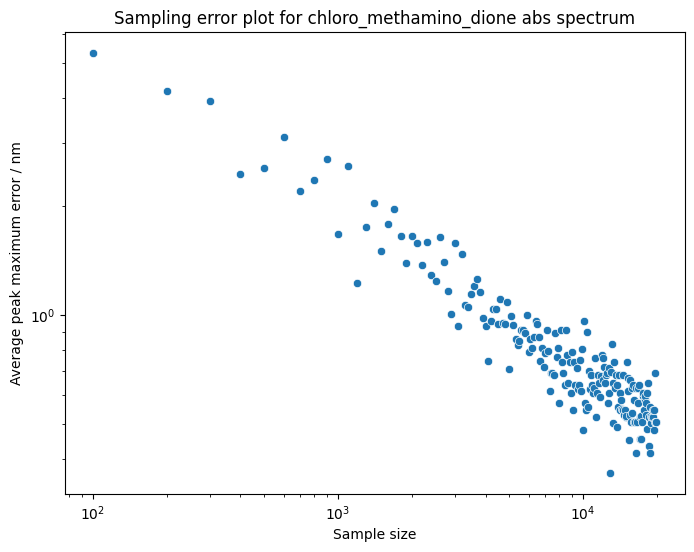

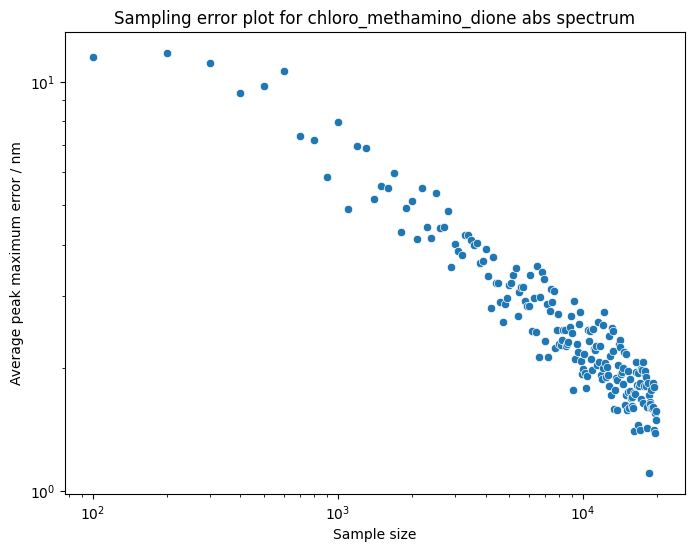

In [10]:
df = pd.DataFrame(lambdas)

# the data can be grouped so that a seperate graph can be plotted for each combination (4 in total)
grouped_df = df.groupby(["Solute", "Solvent", "Spec_Type"])

for name, group in grouped_df:
    plt.figure(figsize=(8, 6))
    
    print(name)
    smpl_lambda_arr = group.groupby("Sample_Size")["Lambda_Max"].std()
    linresult = scipy.stats.linregress(np.log(smpl_lambda_arr.index.values), np.log(smpl_lambda_arr.values))

    print("R2 :", linresult.rvalue**2)
    print("Slope: ", linresult.slope)
    print("Intercept: " ,linresult.intercept)


    print()

    sns.scatterplot(x=smpl_lambda_arr.index.values, y =smpl_lambda_arr.values)
    
    plt
    plt.xscale('log')
    plt.yscale('log')

    plt.ylabel("Average peak maximum error / nm")
    plt.xlabel("Sample size")
    plt.title(f'Sampling error plot for {solute} {spec_type} spectrum')
    

## Task b: Correlation error

The code below produces a separete autocorrelation plot for each of the spectra and broadly show its convergence to 0. Play around with the x-axis range to get more precise values for the required lag time. 

Each time step is 0.5 fs. How many time steps should seperate the samples used to produce each spectrum for them to no longer be correlated? 

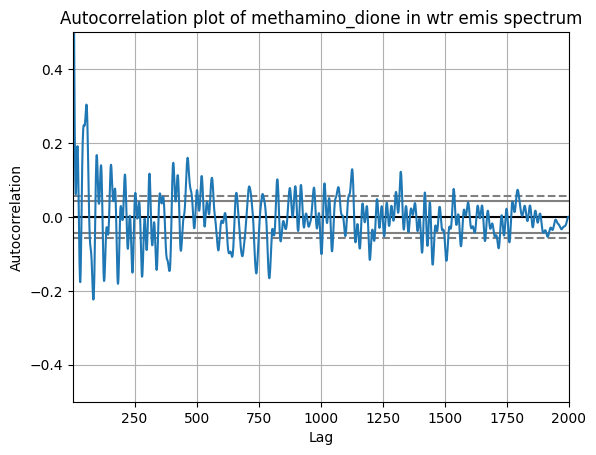

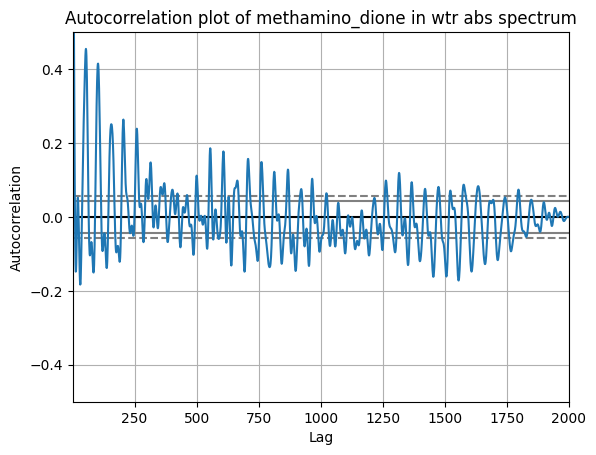

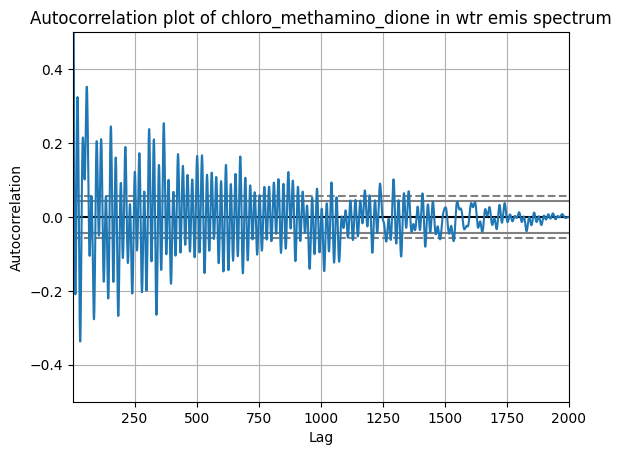

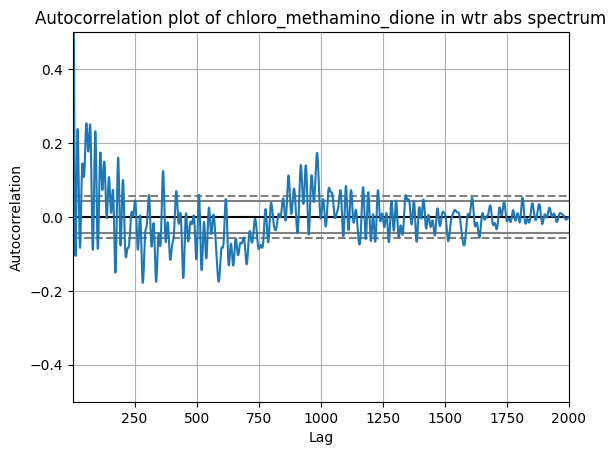

<Figure size 640x480 with 0 Axes>

In [12]:
time_series_tmp = []
time_series = {}

for solv in ["wtr"]:
  for solu in ["methamino_dione", "chloro_methamino_dione"]:

    time_series[f"{solu}"] = {}

    for spec_type in ["emis", "abs"]:

      time_series[f"{solu}"][f"{spec_type}"] = {}

      full_traj = np.load(f"full_stick_spectrum_{solu}_{solv}_{spec_type}.npy")

      # taking the energy gaps from the full dataset
      delta_E = full_traj[:,1]
      time_series_tmp.extend(delta_E)

      # the data needs to be stored as a pandas Series
      time_series[f"{solu}"][f"{spec_type}"] = pd.Series(time_series_tmp)
      time_series_tmp = []

# plotting
for solv in ["wtr"]:
  for solu in ["methamino_dione", "chloro_methamino_dione"]:
    for spec_type in ["emis", "abs"]:

      # the range pf values to be plotted can be adjusted, as well the y-axis limits to more closely look at the convergence of 
      # the autocorrelation to 0 with varying lags. 
      pd.plotting.autocorrelation_plot(time_series[f"{solu}"][f"{spec_type}"][0:2000])
      plt.title(f"Autocorrelation plot of {solu} in {solv} {spec_type} spectrum")
      plt.ylim(-0.5, 0.5)
      plt.figure()